#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *




* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [7]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,100))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [8]:
data = pd.read_csv('/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project5_2/data01_train.csv')

In [9]:
feature = pd.read_csv('/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project5_2/features.csv')

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [10]:
data.shape

(5881, 563)

In [11]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594,17.381568
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479,8.938316
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143,1.000000
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555,8.000000
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951,19.000000
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000,30.000000


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 25.3+ MB


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [13]:
data['Activity'].dtypes

dtype('O')

In [14]:
data['Activity'].value_counts()

LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64

In [15]:
data['Activity'].value_counts(normalize=True)

LAYING                0.189594
STANDING              0.184833
SITTING               0.175480
WALKING               0.169699
WALKING_UPSTAIRS      0.145894
WALKING_DOWNSTAIRS    0.134501
Name: Activity, dtype: float64

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [16]:
feature.groupby('sensor', as_index=False)['feature_name'].nunique()

,sensor,feature_name
0,angle,7
1,fBodyAcc,79
2,fBodyAccJerk,79
3,fBodyAccMag,13
4,fBodyBodyAccJerkMag,13
5,fBodyBodyGyroJerkMag,13
6,fBodyBodyGyroMag,13
7,fBodyGyro,51
8,tBodyAcc,40
9,tBodyAccJerk,40


In [17]:
feature.groupby('agg', as_index=False)['feature_name'].nunique()

,agg,feature_name
0,X,1
1,Y,1
2,Z,1
3,arCoeff(),60
4,arCoeff()1,5
5,arCoeff()2,5
6,arCoeff()3,5
7,arCoeff()4,5
8,bandsEnergy(),98
9,correlation(),15


In [18]:
feature.groupby('axis', as_index=False)['feature_name'].nunique()

,axis,feature_name
0,"1,16",3
1,"1,16.1",2
2,"1,16.2",2
3,"1,24",3
4,"1,24.1",2
...,...,...
57,"Z,2",5
58,"Z,3",5
59,"Z,4",5
60,gravity,1


## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

In [19]:
target = 'Activity'
x = data.drop(target, axis=1)
y  = data.loc[:, target]

In [20]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=0)

In [21]:
model_rf = RandomForestClassifier(random_state=0)
model_rf.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [22]:
result = plot_feature_importance(model_rf.feature_importances_, list(x))

Output hidden; open in https://colab.research.google.com to view.

In [23]:
y_pred = model_rf.predict(x_valid)
print(classification_report(y_pred, y_valid))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       230
           SITTING       0.95      0.97      0.96       202
          STANDING       0.97      0.96      0.96       225
           WALKING       0.99      0.98      0.98       197
WALKING_DOWNSTAIRS       0.97      0.99      0.98       148
  WALKING_UPSTAIRS       1.00      0.99      1.00       175

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



In [24]:
result.head()

,feature_name,feature_importance
0,tGravityAcc-min()-X,0.032152
1,"angle(X,gravityMean)",0.030664
2,tGravityAcc-mean()-Y,0.029844
3,tGravityAcc-mean()-X,0.027946
4,tGravityAcc-min()-Y,0.027303


In [25]:
result.tail()

,feature_name,feature_importance
557,fBodyAccJerk-entropy()-Y,0.000097
558,"fBodyAccJerk-bandsEnergy()-49,56",0.000097
559,"fBodyAccJerk-bandsEnergy()-49,56.1",0.000093
560,tBodyGyroJerkMag-arCoeff()3,0.000075
561,fBodyBodyGyroJerkMag-entropy(),0.000072


### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

### 상위 4개

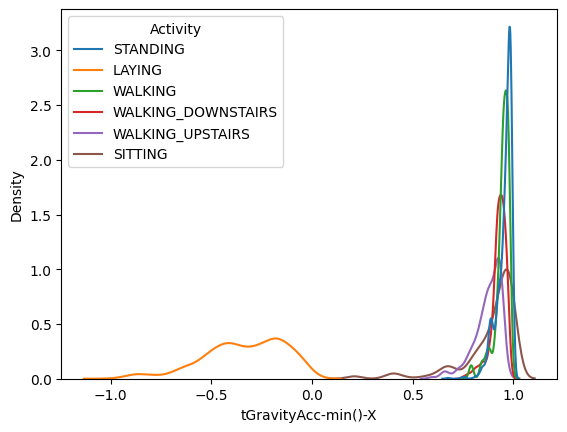

In [26]:
sns.kdeplot(x=list(result['feature_name'])[0], hue='Activity', data=data)
plt.show()

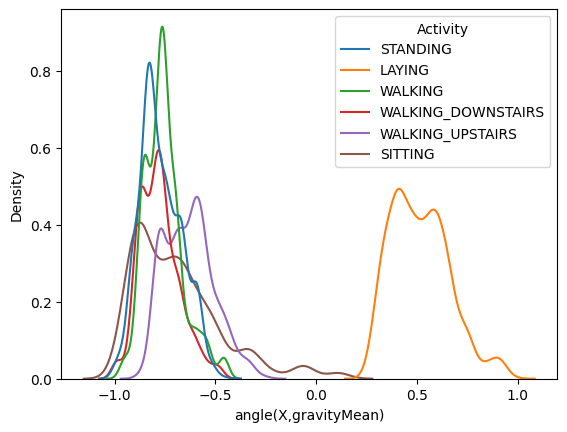

In [27]:
sns.kdeplot(x=list(result['feature_name'])[1], hue='Activity', data=data)
plt.show()

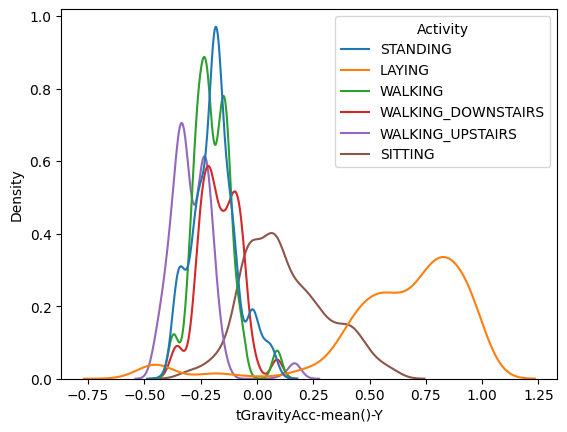

In [28]:
sns.kdeplot(x=list(result['feature_name'])[2], hue='Activity', data=data)
plt.show()

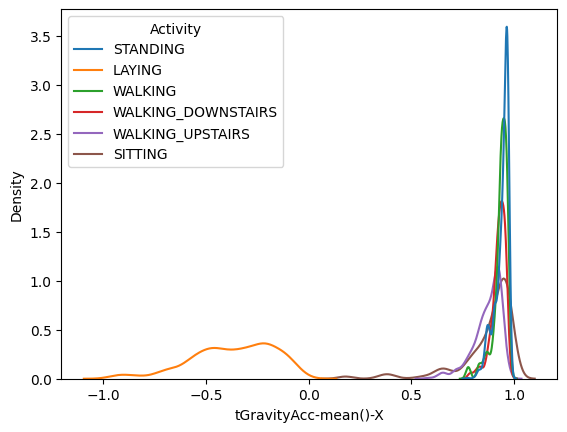

In [29]:
sns.kdeplot(x=list(result['feature_name'])[3], hue='Activity', data=data)
plt.show()

-----------------------

### 하위 4개

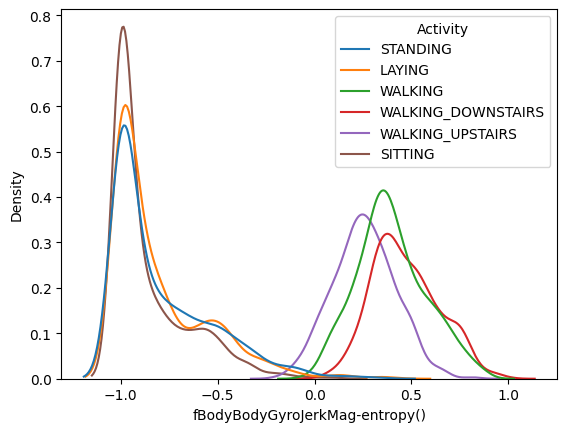

In [30]:
sns.kdeplot(x=list(result['feature_name'])[-1], hue='Activity', data=data)
plt.show()

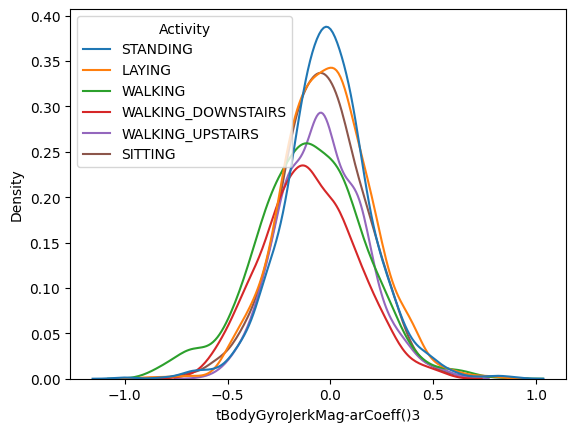

In [31]:
sns.kdeplot(x=list(result['feature_name'])[-2], hue='Activity', data=data)
plt.show()

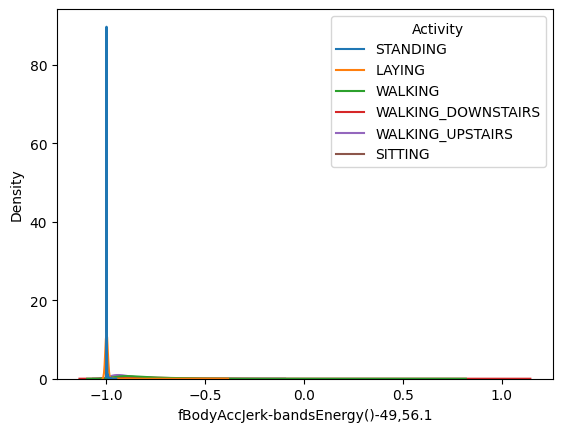

In [32]:
sns.kdeplot(x=list(result['feature_name'])[-3], hue='Activity', data=data)
plt.show()

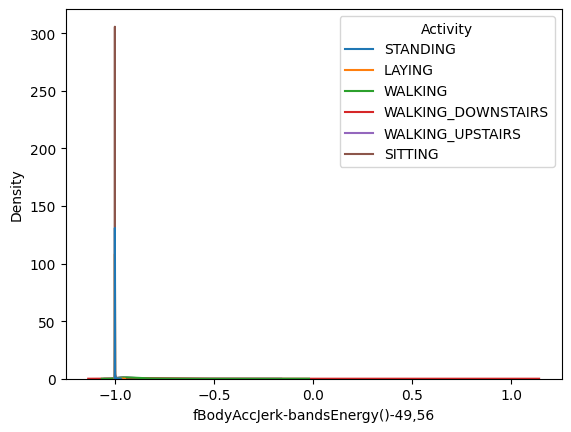

In [33]:
sns.kdeplot(x=list(result['feature_name'])[-4], hue='Activity', data=data)
plt.show()

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.


In [34]:
feature.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


In [35]:
feature.drop_duplicates(inplace=True)

In [36]:
features = pd.merge(feature, result, on='feature_name')

In [37]:
features.groupby('sensor', as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,feature_importance
16,tGravityAcc,0.336563
2,fBodyAccJerk,0.104533
1,fBodyAcc,0.088613
0,angle,0.068804
7,fBodyGyro,0.059210
9,tBodyAccJerk,0.052638
8,tBodyAcc,0.043725
3,fBodyAccMag,0.042312
12,tBodyGyro,0.038926
10,tBodyAccJerkMag,0.037274


In [38]:
features.groupby(['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,agg,feature_importance
197,tGravityAcc,arCoeff(),0.080728
205,tGravityAcc,min(),0.065881
204,tGravityAcc,mean(),0.063576
203,tGravityAcc,max(),0.057131
21,fBodyAccJerk,bandsEnergy(),0.048335
...,...,...,...
75,fBodyBodyGyroMag,entropy(),0.000129
57,fBodyBodyAccJerkMag,min(),0.000126
49,fBodyBodyAccJerkMag,entropy(),0.000113
173,tBodyGyroJerkMag,arCoeff()3,0.000075


## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [39]:
data['is_dynamic'] = 0

In [40]:
data.loc[(data['Activity'] == 'WALKING') | (data['Activity'] == 'WALKING_UPSTAIRS') | (data['Activity'] == 'WALKING_DOWNSTAIRS'), 'is_dynamic'] = 1

In [41]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS,1


#### 2) 기본모델 생성

In [42]:
x = data.drop(['Activity', 'is_dynamic'], axis=1)
y = data.loc[:, 'is_dynamic']

In [43]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=0)

In [44]:
model_rf_2 = RandomForestClassifier(random_state=0)
model_rf_2.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [45]:
y_pred2 = model_rf_2.predict(x_valid)
print(classification_report(y_pred2, y_valid))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       657
           1       1.00      1.00      1.00       520

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



#### 3) 변수중요도 상위 5개 분석

In [46]:
result2 = plot_feature_importance(model_rf_2.feature_importances_, list(x))

Output hidden; open in https://colab.research.google.com to view.

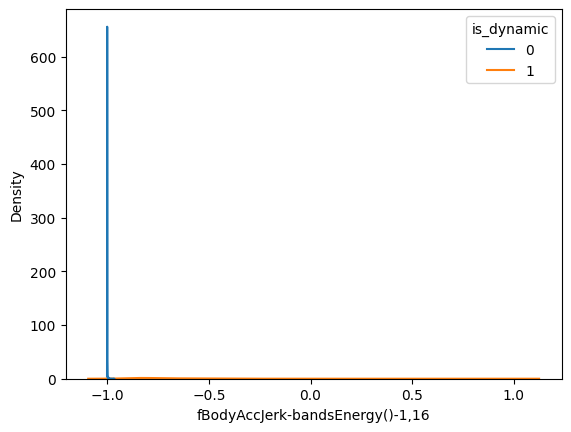

In [47]:
sns.kdeplot(x=list(result2['feature_name'])[0], hue='is_dynamic', data=data)
plt.show()

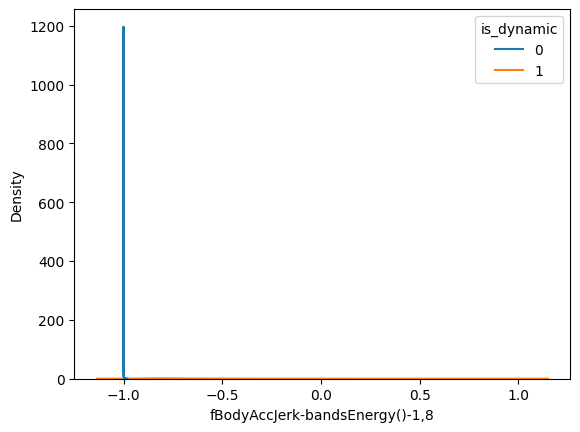

In [48]:
sns.kdeplot(x=list(result2['feature_name'])[1], hue='is_dynamic', data=data)
plt.show()

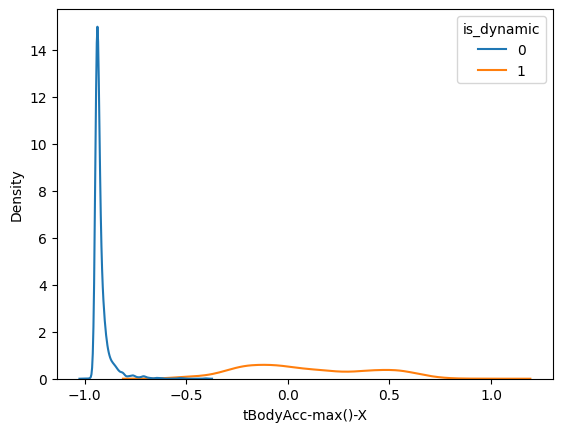

In [49]:
sns.kdeplot(x=list(result2['feature_name'])[2], hue='is_dynamic', data=data)
plt.show()

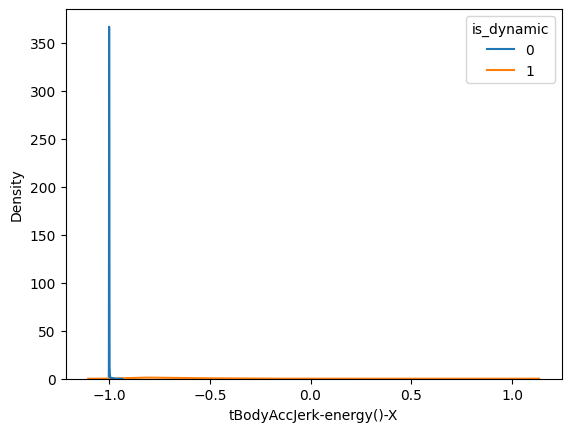

In [50]:
sns.kdeplot(x=list(result2['feature_name'])[3], hue='is_dynamic', data=data)
plt.show()

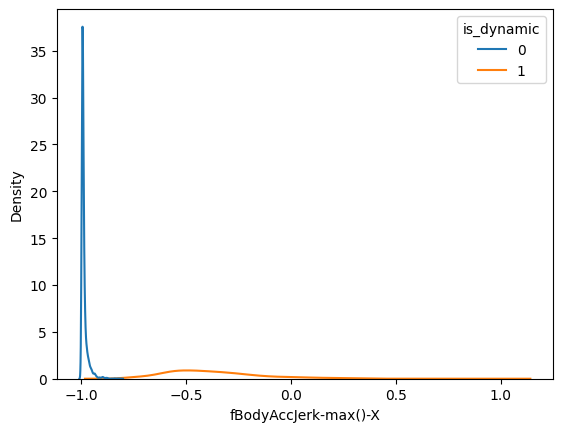

In [51]:
sns.kdeplot(x=list(result2['feature_name'])[4], hue='is_dynamic', data=data)
plt.show()

#### 4) feature 그룹별 분석

In [52]:
features2 = pd.merge(feature, result2, on='feature_name')

In [53]:
features2.groupby('sensor', as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,feature_importance
2,fBodyAccJerk,0.340030
9,tBodyAccJerk,0.200014
1,fBodyAcc,0.119679
10,tBodyAccJerkMag,0.089707
8,tBodyAcc,0.060124
13,tBodyGyroJerk,0.059828
12,tBodyGyro,0.049819
7,fBodyGyro,0.029882
14,tBodyGyroJerkMag,0.019880
4,fBodyBodyAccJerkMag,0.019795


In [54]:
features2.groupby(['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,agg,feature_importance
21,fBodyAccJerk,bandsEnergy(),0.130105
107,tBodyAcc,max(),0.049889
22,fBodyAccJerk,energy(),0.049701
114,tBodyAccJerk,energy(),0.040077
27,fBodyAccJerk,max(),0.040014
...,...,...,...
84,fBodyBodyGyroMag,skewness(),0.000000
85,fBodyBodyGyroMag,sma(),0.000000
86,fBodyBodyGyroMag,std(),0.000000
87,fBodyGyro,bandsEnergy(),0.000000


### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [55]:
data['is_standing'] = 0
data.loc[(data['Activity'] == 'STANDING'), 'is_standing'] = 1

In [56]:
x = data.drop(['Activity', 'is_dynamic', 'is_standing'], axis=1)
y = data.loc[:,'is_standing']

In [57]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=0)

In [58]:
model_rf_3 = RandomForestClassifier(random_state=0)
model_rf_3.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [59]:
y_pred3 = model_rf_3.predict(x_valid)
print(classification_report(y_pred3, y_valid))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       953
           1       0.98      0.96      0.97       224

    accuracy                           0.99      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.99      0.99      0.99      1177



In [60]:
result3 = plot_feature_importance(model_rf_3.feature_importances_, list(x))

Output hidden; open in https://colab.research.google.com to view.

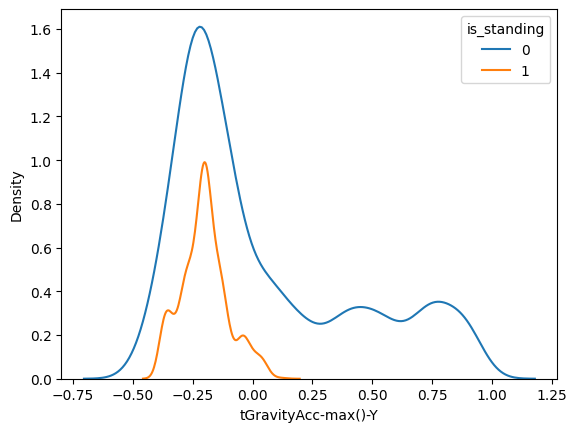

In [61]:
sns.kdeplot(x=list(result3['feature_name'])[0], hue='is_standing', data=data)
plt.show()

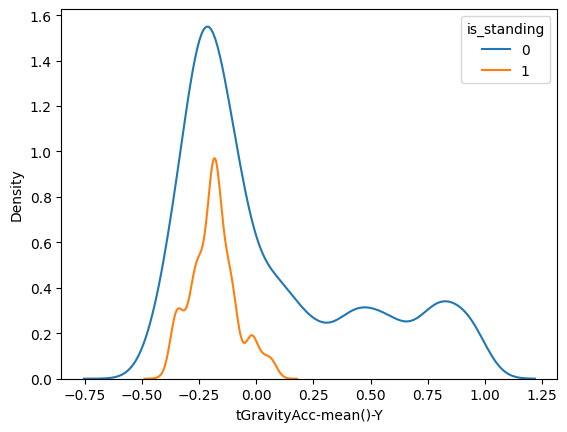

In [62]:
sns.kdeplot(x=list(result3['feature_name'])[1], hue='is_standing', data=data)
plt.show()

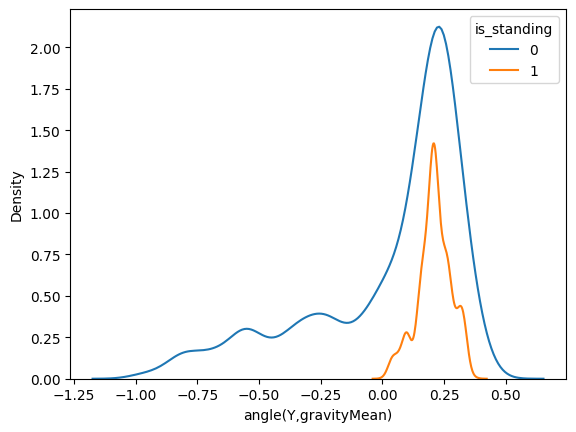

In [63]:
sns.kdeplot(x=list(result3['feature_name'])[2], hue='is_standing', data=data)
plt.show()

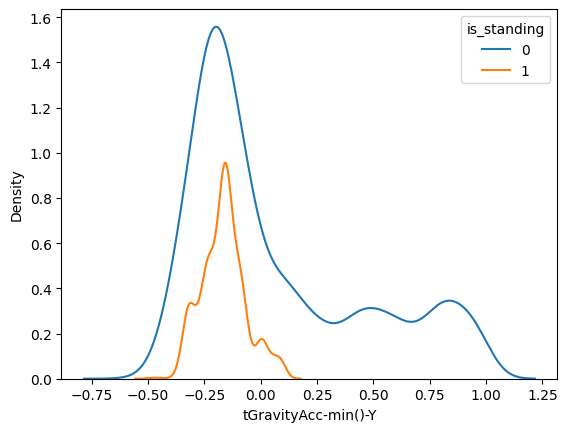

In [64]:
sns.kdeplot(x=list(result3['feature_name'])[3], hue='is_standing', data=data)
plt.show()

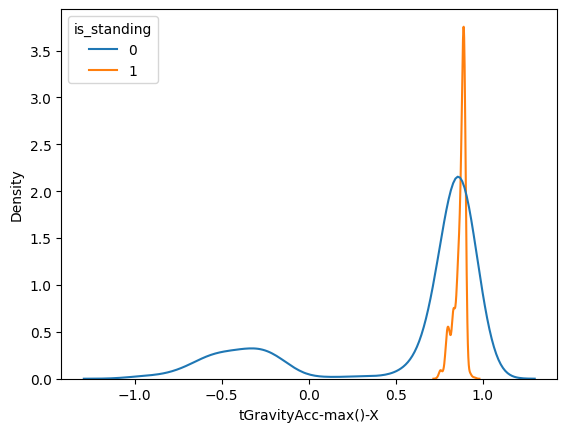

In [65]:
sns.kdeplot(x=list(result3['feature_name'])[4], hue='is_standing', data=data)
plt.show()

In [66]:
features3 = pd.merge(feature, result3, on='feature_name')

In [67]:
features3.groupby('sensor', as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,feature_importance
16,tGravityAcc,0.393796
1,fBodyAcc,0.122611
0,angle,0.094231
7,fBodyGyro,0.073386
12,tBodyGyro,0.068133
8,tBodyAcc,0.048115
2,fBodyAccJerk,0.032948
13,tBodyGyroJerk,0.031721
3,fBodyAccMag,0.022564
11,tBodyAccMag,0.020312


In [68]:
features3.groupby(['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,agg,feature_importance
203,tGravityAcc,max(),0.118934
204,tGravityAcc,mean(),0.091956
205,tGravityAcc,min(),0.081293
1,angle,Y,0.055857
7,fBodyAcc,bandsEnergy(),0.045526
...,...,...,...
48,fBodyBodyAccJerkMag,energy(),0.000094
80,fBodyBodyGyroMag,maxInds,0.000090
67,fBodyBodyGyroJerkMag,maxInds,0.000080
55,fBodyBodyAccJerkMag,mean(),0.000078


### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [69]:
data['is_sitting'] = 0
data.loc[(data['Activity'] == 'SITTING'), 'is_sitting'] = 1
x = data.drop(['Activity', 'is_dynamic', 'is_standing', 'is_sitting'], axis=1)
y = data.loc[:,'is_sitting']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=0)
model_rf_4 = RandomForestClassifier(random_state=0)
model_rf_4.fit(x_train, y_train)
y_pred4 = model_rf_4.predict(x_valid)
print(classification_report(y_pred4, y_valid))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       981
           1       0.93      0.98      0.96       196

    accuracy                           0.98      1177
   macro avg       0.96      0.98      0.97      1177
weighted avg       0.99      0.98      0.98      1177



In [70]:
result4 = plot_feature_importance(model_rf_4.feature_importances_, list(x))

Output hidden; open in https://colab.research.google.com to view.

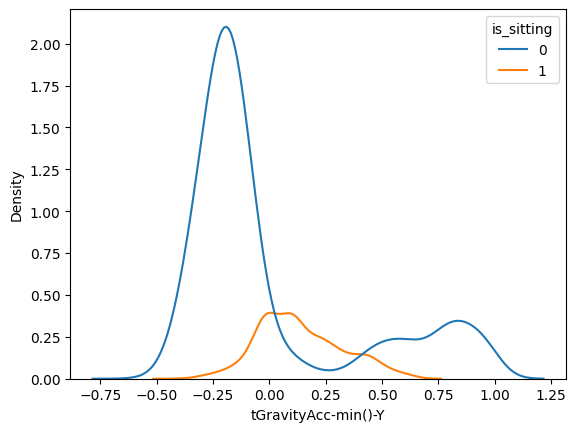

In [71]:
sns.kdeplot(x=list(result4['feature_name'])[0], hue='is_sitting', data=data)
plt.show()

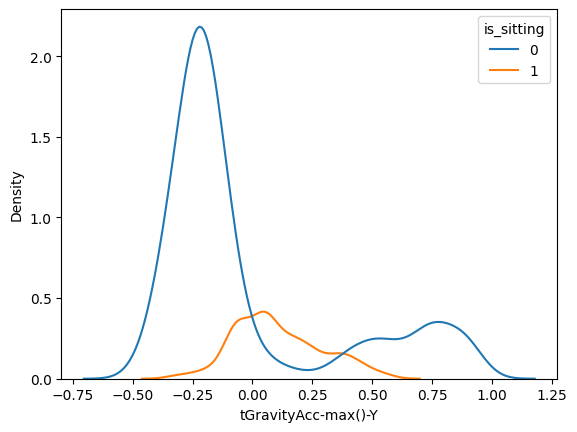

In [72]:
sns.kdeplot(x=list(result4['feature_name'])[1], hue='is_sitting', data=data)
plt.show()

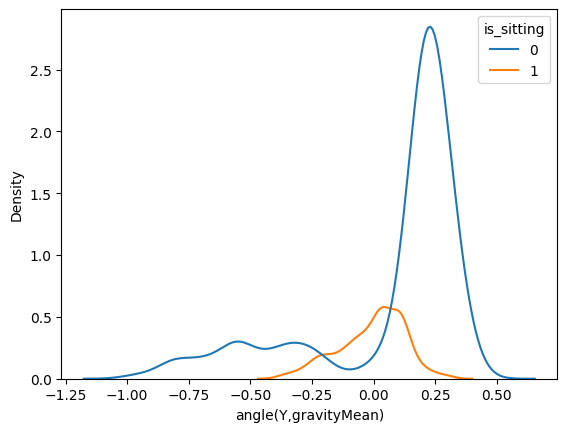

In [73]:
sns.kdeplot(x=list(result4['feature_name'])[2], hue='is_sitting', data=data)
plt.show()

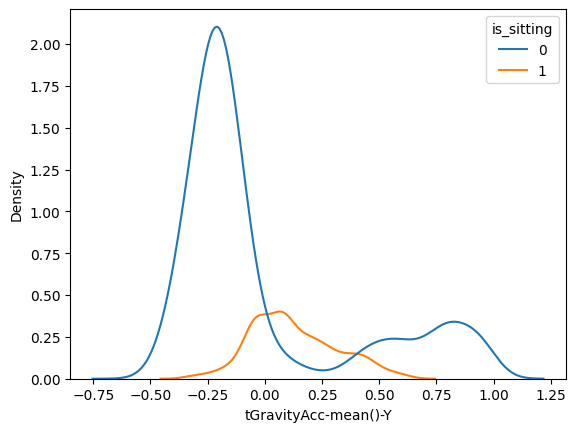

In [74]:
sns.kdeplot(x=list(result4['feature_name'])[3], hue='is_sitting', data=data)
plt.show()

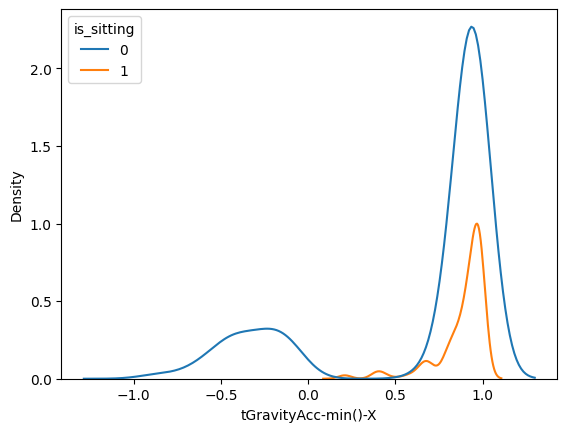

In [75]:
sns.kdeplot(x=list(result4['feature_name'])[4], hue='is_sitting', data=data)
plt.show()

In [76]:
features4 = pd.merge(feature, result4, on='feature_name')

In [77]:
features4.groupby('sensor', as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,feature_importance
16,tGravityAcc,0.333788
7,fBodyGyro,0.154230
0,angle,0.088362
12,tBodyGyro,0.085913
13,tBodyGyroJerk,0.079966
2,fBodyAccJerk,0.050671
1,fBodyAcc,0.042428
8,tBodyAcc,0.038689
14,tBodyGyroJerkMag,0.022097
9,tBodyAccJerk,0.018141


In [78]:
features4.groupby(['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,agg,feature_importance
205,tGravityAcc,min(),0.092583
203,tGravityAcc,max(),0.082693
204,tGravityAcc,mean(),0.065500
87,fBodyGyro,bandsEnergy(),0.051041
199,tGravityAcc,energy(),0.048925
...,...,...,...
210,tGravityAccMag,arCoeff()3,0.000100
36,fBodyAccMag,entropy(),0.000097
179,tBodyGyroJerkMag,max(),0.000086
67,fBodyBodyGyroJerkMag,maxInds,0.000053


### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [79]:
data['is_laying'] = 0
data.loc[(data['Activity'] == 'LAYING'), 'is_laying'] = 1
x = data.drop(['Activity', 'is_dynamic', 'is_standing', 'is_sitting', 'is_laying'], axis=1)
y = data.loc[:,'is_laying']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=0)
model_rf_5 = RandomForestClassifier(random_state=0)
model_rf_5.fit(x_train, y_train)
y_pred5 = model_rf_5.predict(x_valid)
print(classification_report(y_pred5, y_valid))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       947
           1       1.00      1.00      1.00       230

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [80]:
result5 = plot_feature_importance(model_rf_5.feature_importances_, list(x))

Output hidden; open in https://colab.research.google.com to view.

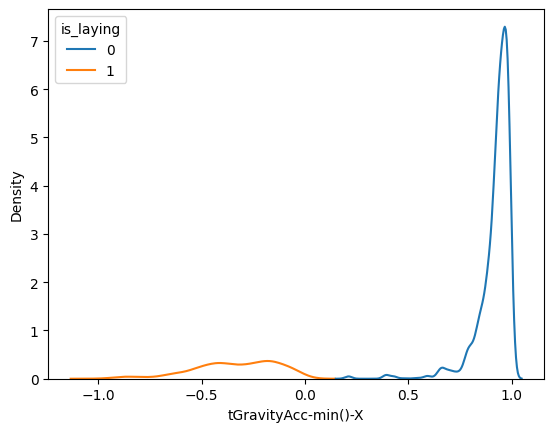

In [81]:
sns.kdeplot(x=list(result5['feature_name'])[0], hue='is_laying', data=data)
plt.show()

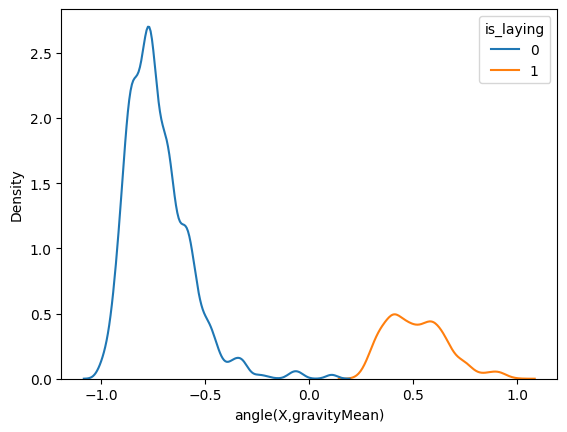

In [82]:
sns.kdeplot(x=list(result5['feature_name'])[1], hue='is_laying', data=data)
plt.show()

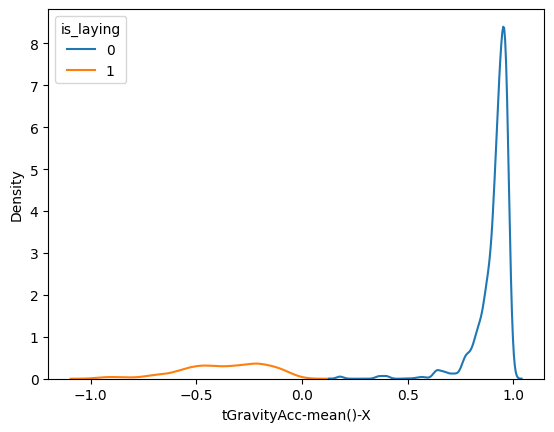

In [83]:
sns.kdeplot(x=list(result5['feature_name'])[2], hue='is_laying', data=data)
plt.show()

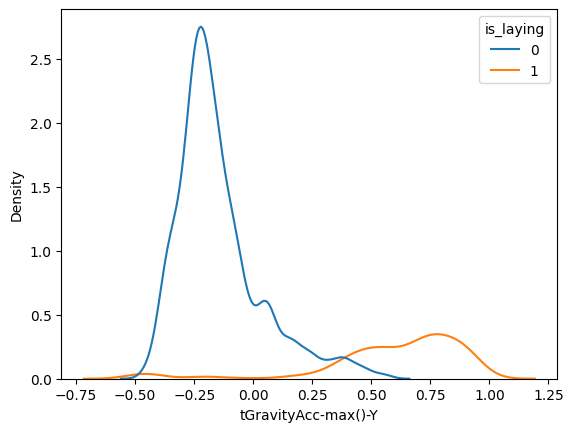

In [84]:
sns.kdeplot(x=list(result5['feature_name'])[3], hue='is_laying', data=data)
plt.show()

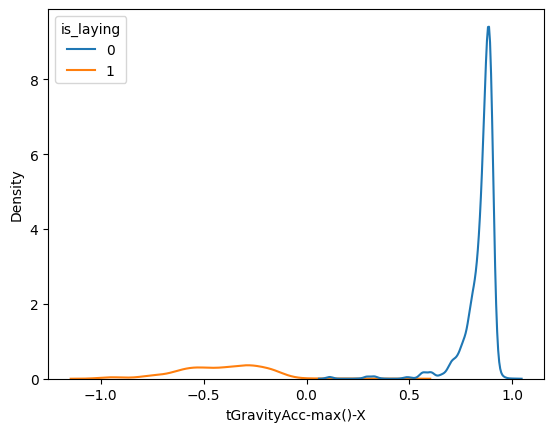

In [85]:
sns.kdeplot(x=list(result5['feature_name'])[4], hue='is_laying', data=data)
plt.show()

In [86]:
features5 = pd.merge(feature, result5, on='feature_name')

In [87]:
features5.groupby('sensor', as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,feature_importance
16,tGravityAcc,0.621401
0,angle,0.193060
1,fBodyAcc,0.033943
2,fBodyAccJerk,0.033372
7,fBodyGyro,0.025461
12,tBodyGyro,0.023938
8,tBodyAcc,0.023748
13,tBodyGyroJerk,0.013959
9,tBodyAccJerk,0.011389
10,tBodyAccJerkMag,0.006695


In [88]:
features5.groupby(['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,agg,feature_importance
204,tGravityAcc,mean(),0.159905
205,tGravityAcc,min(),0.158764
203,tGravityAcc,max(),0.138251
199,tGravityAcc,energy(),0.132202
0,angle,X,0.099464
...,...,...,...
144,tBodyAccMag,max(),0.000000
62,fBodyBodyGyroJerkMag,entropy(),0.000000
58,fBodyBodyAccJerkMag,skewness(),0.000000
191,tBodyGyroMag,mad(),0.000000


### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [89]:
data['is_walking'] = 0
data.loc[(data['Activity'] == 'WALKING'), 'is_walking'] = 1
x = data.drop(['Activity', 'is_dynamic', 'is_standing', 'is_sitting', 'is_laying', 'is_walking'], axis=1)
y = data.loc[:,'is_walking']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=0)
model_rf_6 = RandomForestClassifier(random_state=0)
model_rf_6.fit(x_train, y_train)
y_pred6 = model_rf_6.predict(x_valid)
print(classification_report(y_pred6, y_valid))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       985
           1       0.98      1.00      0.99       192

    accuracy                           1.00      1177
   macro avg       0.99      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [90]:
result6 = plot_feature_importance(model_rf_6.feature_importances_, list(x))

Output hidden; open in https://colab.research.google.com to view.

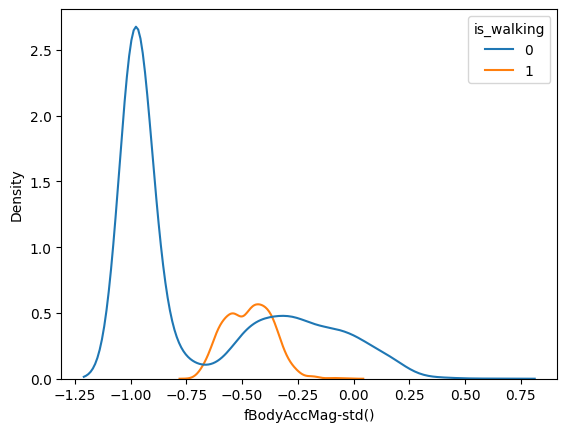

In [91]:
sns.kdeplot(x=list(result6['feature_name'])[0], hue='is_walking', data=data)
plt.show()

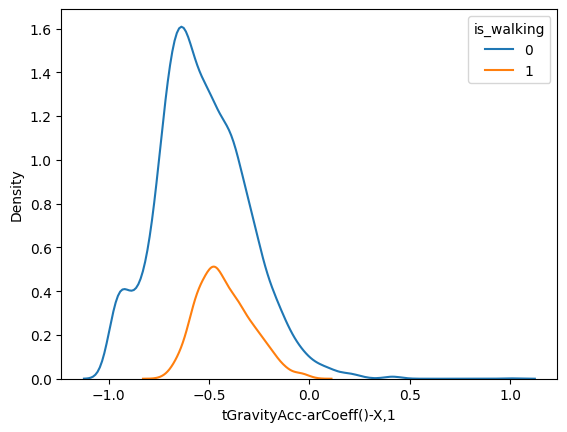

In [92]:
sns.kdeplot(x=list(result6['feature_name'])[1], hue='is_walking', data=data)
plt.show()

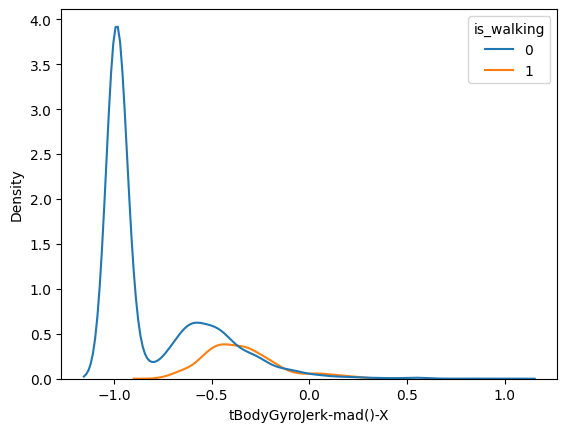

In [93]:
sns.kdeplot(x=list(result6['feature_name'])[2], hue='is_walking', data=data)
plt.show()

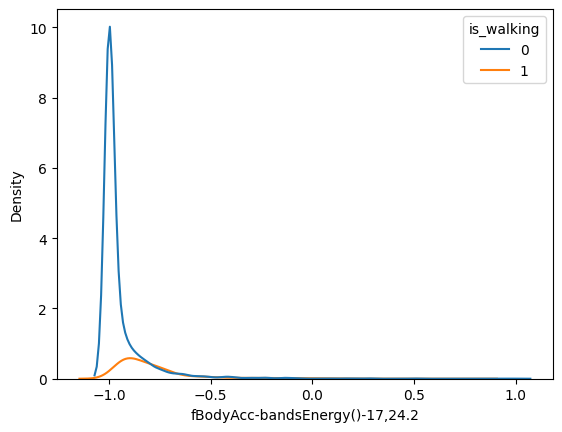

In [94]:
sns.kdeplot(x=list(result6['feature_name'])[3], hue='is_walking', data=data)
plt.show()

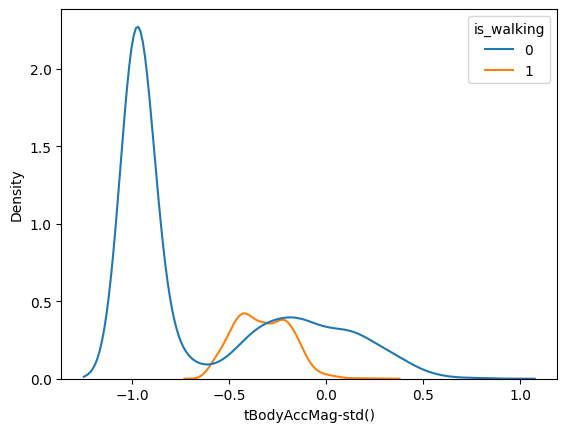

In [95]:
sns.kdeplot(x=list(result6['feature_name'])[4], hue='is_walking', data=data)
plt.show()

In [96]:
features6 = pd.merge(feature, result6, on='feature_name')

In [97]:
features6.groupby('sensor', as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,feature_importance
16,tGravityAcc,0.180682
1,fBodyAcc,0.123606
2,fBodyAccJerk,0.110443
13,tBodyGyroJerk,0.096021
3,fBodyAccMag,0.092125
11,tBodyAccMag,0.069835
7,fBodyGyro,0.054854
17,tGravityAccMag,0.054329
8,tBodyAcc,0.050736
9,tBodyAccJerk,0.047577


In [98]:
features6.groupby(['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,agg,feature_importance
197,tGravityAcc,arCoeff(),0.125238
7,fBodyAcc,bandsEnergy(),0.082225
21,fBodyAccJerk,bandsEnergy(),0.058270
47,fBodyAccMag,std(),0.035612
87,fBodyGyro,bandsEnergy(),0.026729
...,...,...,...
62,fBodyBodyGyroJerkMag,entropy(),0.000038
218,tGravityAccMag,min(),0.000026
81,fBodyBodyGyroMag,mean(),0.000020
44,fBodyAccMag,min(),0.000015


### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [99]:
data['is_walking_up'] = 0
data.loc[(data['Activity'] == 'WALKING_UPSTAIRS'), 'is_walking_up'] = 1
x = data.drop(['Activity', 'is_dynamic', 'is_standing', 'is_sitting', 'is_laying', 'is_walking', 'is_walking_up'], axis=1)
y = data.loc[:,'is_walking_up']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=0)
model_rf_7 = RandomForestClassifier(random_state=0)
model_rf_7.fit(x_train, y_train)
y_pred7 = model_rf_7.predict(x_valid)
print(classification_report(y_pred7, y_valid))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1003
           1       0.99      0.99      0.99       174

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [100]:
result7 = plot_feature_importance(model_rf_7.feature_importances_, list(x))

Output hidden; open in https://colab.research.google.com to view.

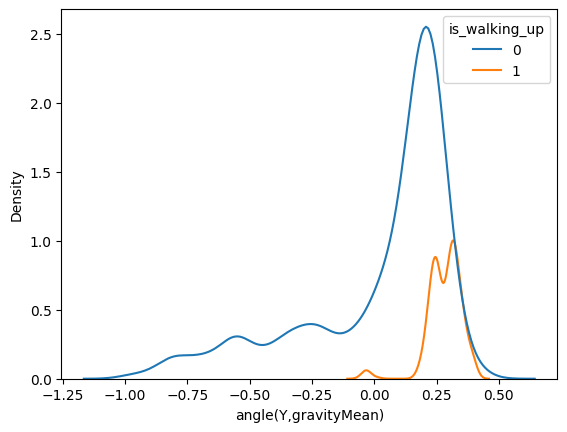

In [101]:
sns.kdeplot(x=list(result7['feature_name'])[0], hue='is_walking_up', data=data)
plt.show()

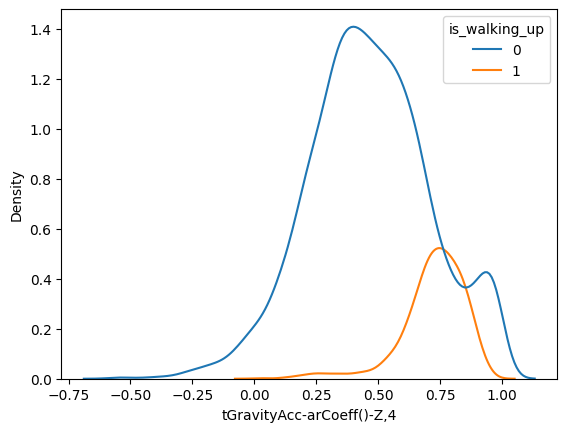

In [102]:
sns.kdeplot(x=list(result7['feature_name'])[1], hue='is_walking_up', data=data)
plt.show()

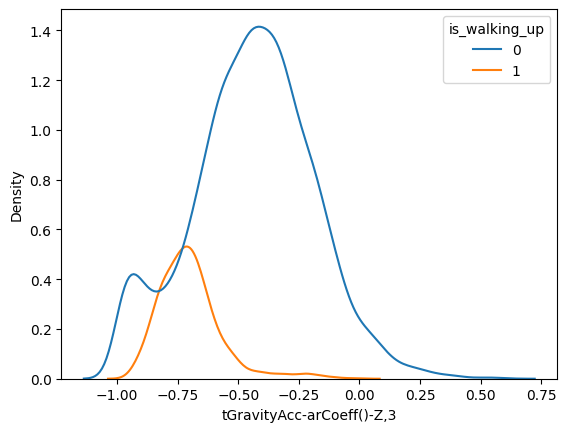

In [103]:
sns.kdeplot(x=list(result7['feature_name'])[2], hue='is_walking_up', data=data)
plt.show()

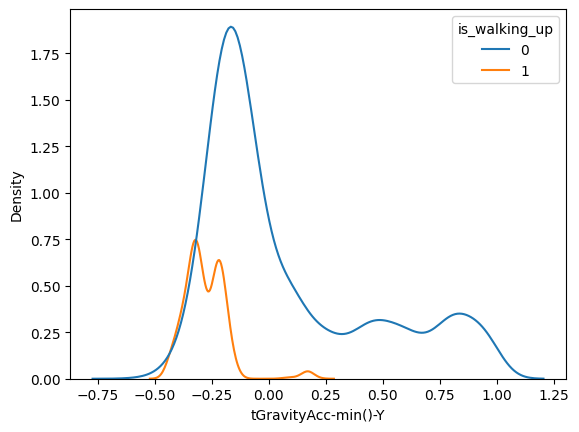

In [104]:
sns.kdeplot(x=list(result7['feature_name'])[3], hue='is_walking_up', data=data)
plt.show()

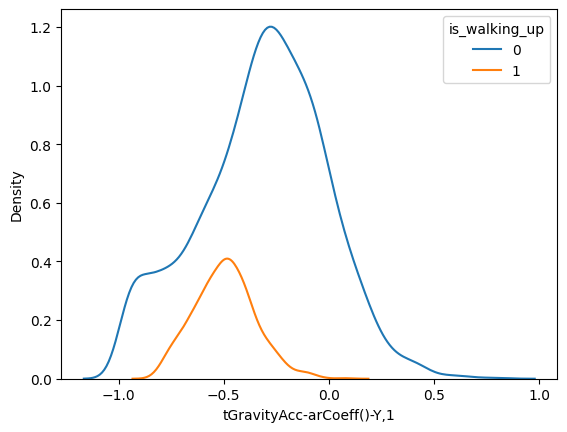

In [105]:
sns.kdeplot(x=list(result7['feature_name'])[4], hue='is_walking_up', data=data)
plt.show()

In [106]:
features7 = pd.merge(feature, result7, on='feature_name')

In [107]:
features7.groupby('sensor', as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,feature_importance
16,tGravityAcc,0.269160
1,fBodyAcc,0.204727
2,fBodyAccJerk,0.123655
9,tBodyAccJerk,0.053546
8,tBodyAcc,0.047833
0,angle,0.043954
7,fBodyGyro,0.040887
10,tBodyAccJerkMag,0.034332
4,fBodyBodyAccJerkMag,0.025875
12,tBodyGyro,0.025870


In [108]:
features7.groupby(['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,agg,feature_importance
197,tGravityAcc,arCoeff(),0.163692
7,fBodyAcc,bandsEnergy(),0.095108
21,fBodyAccJerk,bandsEnergy(),0.060003
13,fBodyAcc,max(),0.040772
205,tGravityAcc,min(),0.033959
...,...,...,...
44,fBodyAccMag,min(),0.000057
80,fBodyBodyGyroMag,maxInds,0.000045
186,tBodyGyroMag,arCoeff()3,0.000042
139,tBodyAccMag,arCoeff()4,0.000039


### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [109]:
data['is_walking_down'] = 0
data.loc[(data['Activity'] == 'WALKING_DOWNSTAIRS'), 'is_walking_down'] = 1
x = data.drop(['Activity', 'is_dynamic', 'is_standing', 'is_sitting', 'is_laying', 'is_walking', 'is_walking_up', 'is_walking_down'], axis=1)
y = data.loc[:,'is_walking_down']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=0)
model_rf_8 = RandomForestClassifier(random_state=0)
model_rf_8.fit(x_train, y_train)
y_pred8 = model_rf_8.predict(x_valid)
print(classification_report(y_pred8, y_valid))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1033
           1       0.95      0.99      0.97       144

    accuracy                           0.99      1177
   macro avg       0.97      0.99      0.98      1177
weighted avg       0.99      0.99      0.99      1177



In [110]:
result8 = plot_feature_importance(model_rf_8.feature_importances_, list(x))

Output hidden; open in https://colab.research.google.com to view.

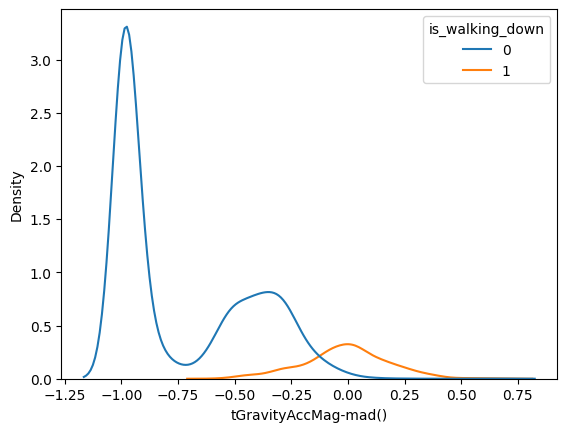

In [111]:
sns.kdeplot(x=list(result8['feature_name'])[0], hue='is_walking_down', data=data)
plt.show()

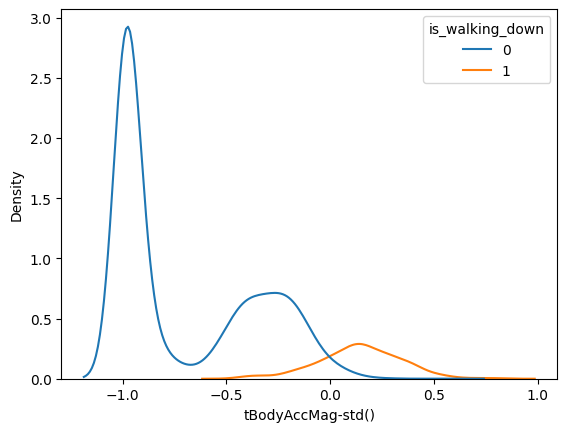

In [112]:
sns.kdeplot(x=list(result8['feature_name'])[1], hue='is_walking_down', data=data)
plt.show()

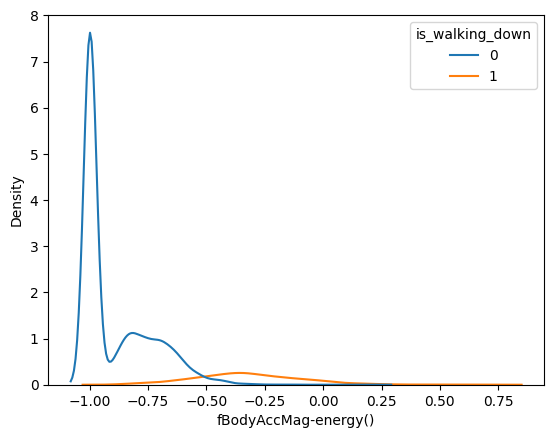

In [113]:
sns.kdeplot(x=list(result8['feature_name'])[2], hue='is_walking_down', data=data)
plt.show()

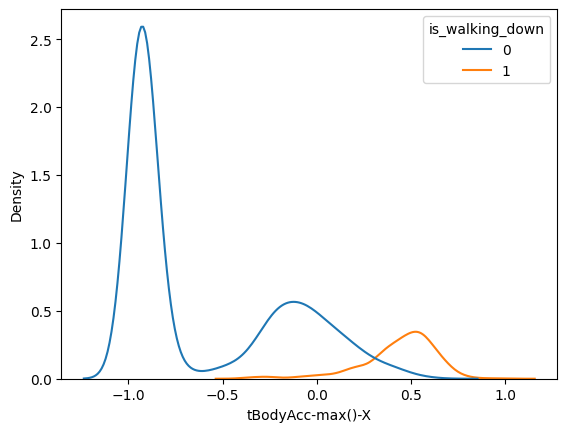

In [114]:
sns.kdeplot(x=list(result8['feature_name'])[3], hue='is_walking_down', data=data)
plt.show()

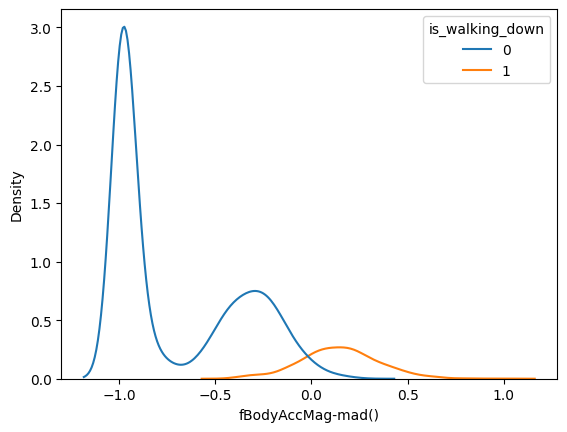

In [115]:
sns.kdeplot(x=list(result8['feature_name'])[4], hue='is_walking_down', data=data)
plt.show()

In [116]:
features8 = pd.merge(feature, result8, on='feature_name')

In [117]:
features8.groupby('sensor', as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,feature_importance
3,fBodyAccMag,0.182091
1,fBodyAcc,0.161448
8,tBodyAcc,0.113258
11,tBodyAccMag,0.110979
2,fBodyAccJerk,0.105795
17,tGravityAccMag,0.092899
9,tBodyAccJerk,0.051492
16,tGravityAcc,0.046544
7,fBodyGyro,0.030100
12,tBodyGyro,0.023843


In [118]:
features8.groupby(['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,agg,feature_importance
21,fBodyAccJerk,bandsEnergy(),0.067830
215,tGravityAccMag,mad(),0.044002
148,tBodyAccMag,std(),0.043033
35,fBodyAccMag,energy(),0.042492
7,fBodyAcc,bandsEnergy(),0.041463
...,...,...,...
62,fBodyBodyGyroJerkMag,entropy(),0.000036
83,fBodyBodyGyroMag,min(),0.000028
181,tBodyGyroJerkMag,min(),0.000019
183,tBodyGyroJerkMag,std(),0.000016


## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

In [119]:
features.rename(columns={'feature_importance':'관점1'}, inplace=True)
features2.rename(columns={'feature_importance':'관점2'}, inplace=True)
features3.rename(columns={'feature_importance':'관점3'}, inplace=True)
features4.rename(columns={'feature_importance':'관점4'}, inplace=True)
features5.rename(columns={'feature_importance':'관점5'}, inplace=True)
features6.rename(columns={'feature_importance':'관점6'}, inplace=True)
features7.rename(columns={'feature_importance':'관점7'}, inplace=True)
features8.rename(columns={'feature_importance':'관점8'}, inplace=True)

In [121]:
for i in [features2,features3,features4,features5,features6,features7,features8]:
    features = pd.merge(features, i)
features.head()

,sensor,agg,axis,feature_name,관점1,관점2,관점3,관점4,관점5,관점6,관점7,관점8
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000264,0.000026,0.000254,0.000190,0.000058,0.000051,0.000480,0.000233
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000306,0.000033,0.000614,0.000453,0.000177,0.000224,0.000870,0.000119
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000161,0.000000,0.000294,0.000175,0.000132,0.000041,0.000268,0.000149
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.003584,0.009932,0.003414,0.000494,0.000952,0.002813,0.004036,0.011615
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000320,0.000000,0.000719,0.000791,0.000366,0.000396,0.000839,0.001019


In [123]:
display(features2.head(1))
display(features3.head(1))

,sensor,agg,axis,feature_name,관점2
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000026


,sensor,agg,axis,feature_name,관점3
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000254


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [125]:
import pickle
with open('total.pkl','wb') as fw:
    pickle.dump(features, fw)

In [126]:
with open('total.pkl', 'rb') as f:
    read = pickle.load(f)

In [127]:
read.head()

,sensor,agg,axis,feature_name,관점1,관점2,관점3,관점4,관점5,관점6,관점7,관점8
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000264,0.000026,0.000254,0.000190,0.000058,0.000051,0.000480,0.000233
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000306,0.000033,0.000614,0.000453,0.000177,0.000224,0.000870,0.000119
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000161,0.000000,0.000294,0.000175,0.000132,0.000041,0.000268,0.000149
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.003584,0.009932,0.003414,0.000494,0.000952,0.002813,0.004036,0.011615
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000320,0.000000,0.000719,0.000791,0.000366,0.000396,0.000839,0.001019
